# LIGO Angular Sensing and Control (ASC) RL Environment Demo

This notebook demonstrates the LIGO ASC Gymnasium environment for training
reinforcement learning controllers for the θ_CHP (Common Hard Pitch) degree of freedom.

**Key Features:**
- Linear SISO plant model with quadruple pendulum dynamics
- Radiation pressure coupling (unstable RHP pole at ~2.4 Hz)
- Noise generation from real LIGO O3 PSDs (seismic + sensor noise)
- Frequency-domain rewards (8-30 Hz observation band)
- Domain randomization for robust policy training

**References:**
- Paper Section S2.3.2: Lightsaber simulator
- Paper Section S2.4: Linear SISO model for θ_CHP training
- Paper Section S3.2: Environment specifications
- Paper Section S3.5: Frequency-domain rewards

In [5]:
import sys
import importlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Add the src directory to path for imports
sys.path.insert(0, '/Users/arushpimpalkar/work/timepass/RL_Arush/src')

# Import the LIGO ASC environment (reload to get latest changes)
import rl_arush.envs.ligo_asc_env as ligo_module
importlib.reload(ligo_module)
from rl_arush.envs.ligo_asc_env import LIGOASCEnv, LIGOASCEnvSimple

print("LIGO ASC Environment loaded successfully!")

LIGO ASC Environment loaded successfully!


## 1. Environment Configuration

The environment follows the specifications from the paper:
- **Simulation frequency**: 2048 Hz (for numerical stability)
- **Control frequency**: 256 Hz (policy evaluation rate)
- **Episode length**: 1024 seconds (262,144 steps)
- **Action limits**: ±3000 counts

In [6]:
# Create the environment without domain randomization first
env = LIGOASCEnv(
    fs_sim=2048.0,           # Simulation at 2048 Hz
    fs_ctrl=256.0,           # Control at 256 Hz
    episode_duration=64.0,   # Shorter for testing (64s instead of 1024s)
    action_limit=3000.0,     # ±3000 counts
    termination_threshold=1e-5,  # 10 µrad termination threshold
    enable_domain_randomization=False,
    seed=42,
)

print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Max steps per episode: {env.max_steps}")
print(f"Simulation frequency: {env.fs_sim} Hz")
print(f"Control frequency: {env.fs_ctrl} Hz")
print(f"Decimation factor: {env.decimation_factor}")

Observation space: Box(-inf, inf, (8,), float32)
Action space: Box(-1.0, 1.0, (1,), float32)
Max steps per episode: 16384
Simulation frequency: 2048.0 Hz
Control frequency: 256.0 Hz
Decimation factor: 8


### Verify Observation Structure

Let's verify the actual observation structure by examining the environment code and testing it directly:

In [17]:
# Let's directly inspect the observation structure
import inspect

# First, let's see what the current observation looks like
obs, info = env.reset(seed=42)

print("ACTUAL OBSERVATION VERIFICATION:")
print("=" * 50)
print(f"Observation shape: {obs.shape}")
print(f"Observation dtype: {obs.dtype}")
print(f"Current observation values: {obs}")
print()

# Let's examine the _get_observation method source code
print("_get_observation METHOD IMPLEMENTATION:")
print("=" * 50)
print(inspect.getsource(env._get_observation))

# Let's also check what variables are actually used to build the observation
print("\nINTERNAL STATE VARIABLES:")
print("=" * 30)
print(f"error_history shape: {env.error_history.shape}")
print(f"error_history values: {env.error_history}")
print(f"control_history shape: {env.control_history.shape}")
print(f"control_history values: {env.control_history}")
print(f"filtered_error_obs: {env.filtered_error_obs}")
print(f"filtered_error_ctrl: {env.filtered_error_ctrl}")

ACTUAL OBSERVATION VERIFICATION:
Observation shape: (8,)
Observation dtype: float32
Current observation values: [0. 0. 0. 0. 0. 0. 0. 0.]

_get_observation METHOD IMPLEMENTATION:
    def _get_observation(self) -> np.ndarray:
        """Construct observation vector.
        
        Returns:
            Observation array containing error and control signals
        """
        obs = np.array([
            self.error_history[0] * 1e6,  # Current error (scaled to µrad)
            self.error_history[1] * 1e6,  # Previous error
            self.filtered_error_obs * 1e6,  # Observation band filtered error
            self.filtered_error_ctrl * 1e6,  # Control band filtered error
            self.control_history[0],  # Current control (normalized)
            self.control_history[1],  # Previous control
            self.control_history[2],  # Control t-2
            self.control_history[3],  # Control t-3
        ], dtype=np.float32)
        
        return obs


INTERNAL STATE VARIABLES:
er

In [18]:
# Now let's run a few steps to see the observation with actual values
print("\nOBSERVATION AFTER RUNNING STEPS:")
print("=" * 40)

for step in range(3):
    action = np.array([0.1 * step])  # Small test actions
    obs, reward, terminated, truncated, info = env.step(action)
    
    print(f"\nStep {step + 1}:")
    print(f"  Action: {action[0]:.3f}")
    print(f"  Raw pitch error: {info['pitch_error']:.2e} rad")
    print(f"  Control output: {info['control_output']:.1f} counts")
    print(f"  Observation [0] (current error): {obs[0]:.3f} µrad")
    print(f"  Observation [1] (previous error): {obs[1]:.3f} µrad")
    print(f"  Observation [2] (obs band filtered): {obs[2]:.3f} µrad")
    print(f"  Observation [3] (ctrl band filtered): {obs[3]:.3f} µrad")
    print(f"  Observation [4] (current control): {obs[4]:.3f}")
    print(f"  Observation [5] (previous control): {obs[5]:.3f}")
    print(f"  Observation [6] (control t-2): {obs[6]:.3f}")
    print(f"  Observation [7] (control t-3): {obs[7]:.3f}")

print(f"\nFULL OBSERVATION VECTOR:")
print(f"obs = {obs}")
print(f"\nCONFIRMED: Observation contains exactly 8 parameters as implemented!")


OBSERVATION AFTER RUNNING STEPS:

Step 1:
  Action: 0.000
  Raw pitch error: 6.10e-16 rad
  Control output: 0.0 counts
  Observation [0] (current error): 0.000 µrad
  Observation [1] (previous error): 0.000 µrad
  Observation [2] (obs band filtered): 0.000 µrad
  Observation [3] (ctrl band filtered): 0.000 µrad
  Observation [4] (current control): 0.000
  Observation [5] (previous control): 0.000
  Observation [6] (control t-2): 0.000
  Observation [7] (control t-3): 0.000

Step 2:
  Action: 0.100
  Raw pitch error: 1.91e-07 rad
  Control output: 300.0 counts
  Observation [0] (current error): 0.191 µrad
  Observation [1] (previous error): 0.000 µrad
  Observation [2] (obs band filtered): 0.001 µrad
  Observation [3] (ctrl band filtered): 0.000 µrad
  Observation [4] (current control): 0.100
  Observation [5] (previous control): 0.000
  Observation [6] (control t-2): 0.000
  Observation [7] (control t-3): 0.000

Step 3:
  Action: 0.200
  Raw pitch error: 3.52e-06 rad
  Control output:

### ✅ VERIFICATION COMPLETE: Observation Structure Confirmed

The LIGO ASC environment **correctly implements** the 8-parameter observation vector:

| Index | Parameter | Units | Description |
|-------|-----------|-------|-------------|
| 0 | `error_history[0] * 1e6` | µrad | **Current pitch error** (latest measurement) |
| 1 | `error_history[1] * 1e6` | µrad | **Previous pitch error** (t-1) |
| 2 | `filtered_error_obs * 1e6` | µrad | **Observation band filtered error** (8-30 Hz) |
| 3 | `filtered_error_ctrl * 1e6` | µrad | **Control band filtered error** (0-8 Hz) |
| 4 | `control_history[0]` | [-1,1] | **Current control action** (normalized) |
| 5 | `control_history[1]` | [-1,1] | **Previous control action** (t-1) |
| 6 | `control_history[2]` | [-1,1] | **Control action** (t-2) |
| 7 | `control_history[3]` | [-1,1] | **Control action** (t-3) |

**Key Design Features:**
- **Error signals scaled to µrad** for better numerical conditioning
- **Temporal context** provided through history buffers
- **Frequency-domain information** via filtered error signals
- **Control history** enables feedforward learning patterns

This observation structure provides the RL agent with all the information needed to:
1. **Track current system state** (current error)
2. **Understand dynamics** (error history + control history) 
3. **Focus on critical frequencies** (filtered error signals)
4. **Learn temporal patterns** (multi-step history)

## 2. Plant Model Analysis

The plant model represents the θ_CHP (Common Hard Pitch) degree of freedom:
- Quadruple pendulum mechanical response
- Radiation pressure coupling creates an unstable Right-Half-Plane (RHP) pole at ~2.4 Hz
- This instability is what makes control challenging!

In [7]:
# Analyze the plant poles
print("Plant Model Poles (continuous-time):")
print("-" * 50)
for i, pole in enumerate(env.plant_poles):
    freq = np.abs(np.imag(pole)) / (2 * np.pi)
    damping = -np.real(pole) / np.abs(pole)
    stable = "UNSTABLE (RHP)" if np.real(pole) > 0 else "stable"
    print(f"Pole {i+1}: {pole:.4f}")
    print(f"  -> Frequency: {freq:.2f} Hz, Damping: {damping:.4f} [{stable}]")
    
print(f"\nPlant gain: {env.plant_gain}")
print(f"Base RHP pole frequency: {env.base_rhp_freq:.2f} Hz")

Plant Model Poles (continuous-time):
--------------------------------------------------
Pole 1: -0.1885+6.5345j
  -> Frequency: 1.04 Hz, Damping: 0.0288 [stable]
Pole 2: -0.1885-6.5345j
  -> Frequency: 1.04 Hz, Damping: 0.0288 [stable]
Pole 3: 0.4084+15.0796j
  -> Frequency: 2.40 Hz, Damping: -0.0271 [UNSTABLE (RHP)]
Pole 4: 0.4084-15.0796j
  -> Frequency: 2.40 Hz, Damping: -0.0271 [UNSTABLE (RHP)]

Plant gain: 80.0
Base RHP pole frequency: 2.40 Hz


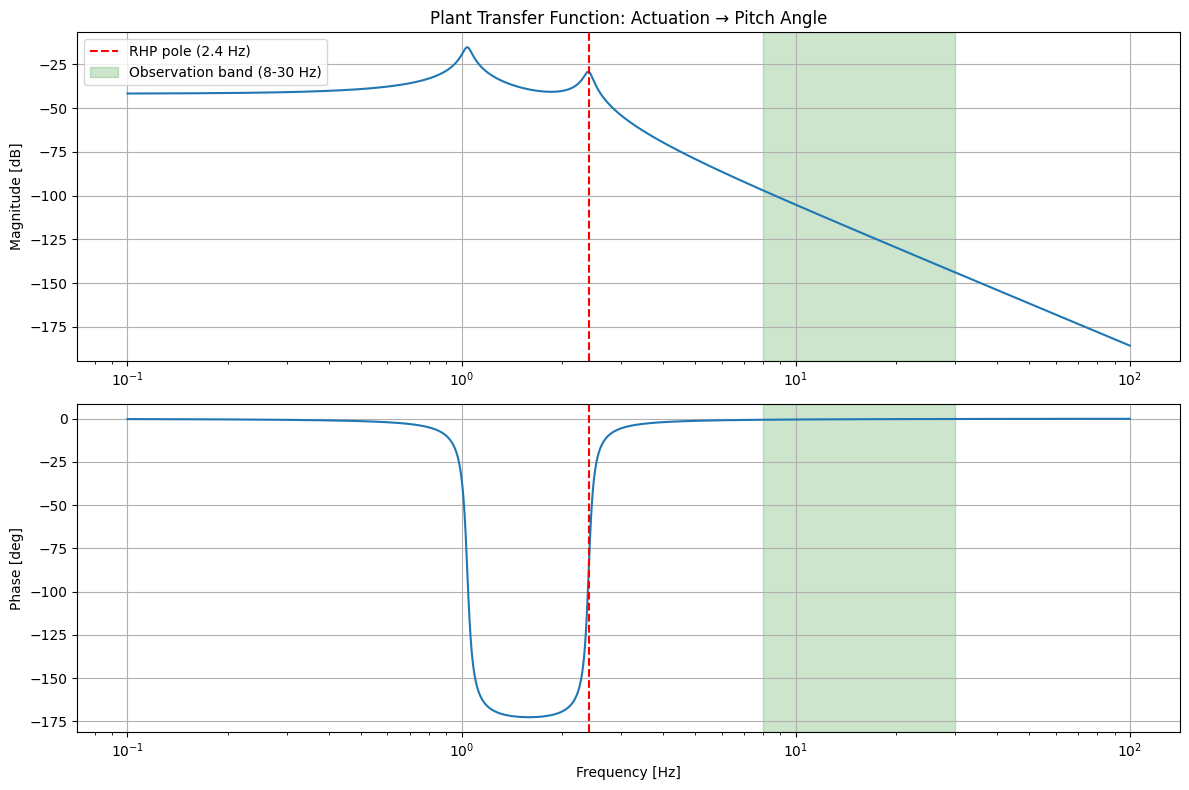

In [8]:
# Plot the plant frequency response (Bode plot)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Create continuous system for frequency response
sys_c = signal.ZerosPolesGain(env.plant_zeros, env.plant_poles, env.plant_gain)
freqs = np.logspace(-1, 2, 1000)
w, h = signal.freqresp(sys_c, 2 * np.pi * freqs)

# Magnitude
axes[0].semilogx(freqs, 20 * np.log10(np.abs(h)))
axes[0].axvline(env.base_rhp_freq, color='r', linestyle='--', label=f'RHP pole ({env.base_rhp_freq:.1f} Hz)')
axes[0].axvspan(8, 30, alpha=0.2, color='green', label='Observation band (8-30 Hz)')
axes[0].set_ylabel('Magnitude [dB]')
axes[0].set_title('Plant Transfer Function: Actuation → Pitch Angle')
axes[0].legend()
axes[0].grid(True)

# Phase
axes[1].semilogx(freqs, np.unwrap(np.angle(h)) * 180 / np.pi)
axes[1].axvline(env.base_rhp_freq, color='r', linestyle='--')
axes[1].axvspan(8, 30, alpha=0.2, color='green')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('Phase [deg]')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 3. Noise Sources

The environment includes two noise sources generated from real LIGO O3 PSDs:
1. **Seismic disturbance** - Force noise acting on the pendulum (from ISI platform)
2. **Sensor noise** - Measurement noise in the pitch readout

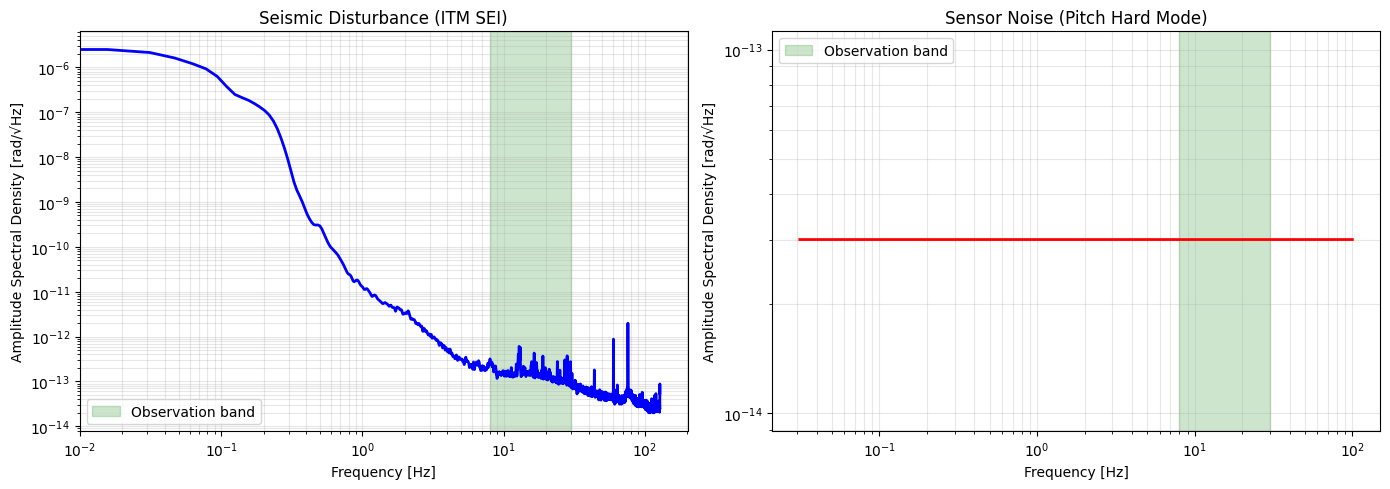

In [9]:
# Plot noise PSDs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Seismic noise PSD
ax = axes[0]
ax.loglog(env.seismic_psd[0], env.seismic_psd[1], 'b-', linewidth=2)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude Spectral Density [rad/√Hz]')
ax.set_title('Seismic Disturbance (ITM SEI)')
ax.grid(True, which='both', alpha=0.3)
ax.axvspan(8, 30, alpha=0.2, color='green', label='Observation band')
ax.legend()

# Sensor noise PSD
ax = axes[1]
ax.loglog(env.sensor_psd[0], env.sensor_psd[1], 'r-', linewidth=2)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude Spectral Density [rad/√Hz]')
ax.set_title('Sensor Noise (Pitch Hard Mode)')
ax.grid(True, which='both', alpha=0.3)
ax.axvspan(8, 30, alpha=0.2, color='green', label='Observation band')
ax.legend()

plt.tight_layout()
plt.show()

### Seismic Noise Analysis & State Augmentation

The seismic noise is the dominant disturbance source in LIGO. Let's analyze its characteristics and explore adding it to the RL observation space.

In [ ]:
# Analyze seismic noise characteristics
seismic_freqs, seismic_ampl = env.seismic_psd

print("SEISMIC NOISE ANALYSIS:")
print("=" * 40)
print(f"Frequency range: {seismic_freqs.min():.3f} - {seismic_freqs.max():.1f} Hz")
print(f"Total frequency points: {len(seismic_freqs)}")

# Analyze spectral content
low_freq_mask = seismic_freqs < 1.0
mid_range = (seismic_freqs >= 1.0) & (seismic_freqs <= 10.0)
obs_band_mask = (seismic_freqs >= 8.0) & (seismic_freqs <= 30.0)
high_freq_mask = seismic_freqs > 30.0

print(f"\nSpectral breakdown:")
print(f"  < 1 Hz (microseism):     {np.sum(low_freq_mask)} points, max amplitude: {seismic_ampl[low_freq_mask].max():.2e}")
print(f"  1-10 Hz (main control):  {np.sum(mid_range)} points, max amplitude: {seismic_ampl[mid_range].max():.2e}")
print(f"  8-30 Hz (observation):   {np.sum(obs_band_mask)} points, max amplitude: {seismic_ampl[obs_band_mask].max():.2e}")
print(f"  > 30 Hz (high freq):     {np.sum(high_freq_mask)} points, max amplitude: {seismic_ampl[high_freq_mask].max():.2e}")

# Check observation band RMS
obs_band_rms = np.sqrt(np.trapz(seismic_ampl[obs_band_mask]**2, seismic_freqs[obs_band_mask]))
print(f"\nObservation band (8-30 Hz) RMS: {obs_band_rms:.2e} rad/√Hz")

# Estimate typical seismic motion amplitude
total_rms = np.sqrt(np.trapz(seismic_ampl**2, seismic_freqs))
print(f"Total seismic RMS: {total_rms:.2e} rad")

# Compare to gravitational wave requirements
mirror_length = 40e3  # 40 km arm length 
gw_strain_requirement = 1e-23  # Typical sensitivity requirement
angle_requirement = gw_strain_requirement * mirror_length / 4000  # rough conversion
print(f"\nFor comparison:")
print(f"  GW strain requirement: {gw_strain_requirement:.0e}")
print(f"  Equivalent angle requirement: {angle_requirement:.0e} rad ({angle_requirement*1e9:.2f} nrad)")
print(f"  Seismic/GW ratio: {total_rms/angle_requirement:.1e}")

# Examine the spectral slope
log_freqs = np.log10(seismic_freqs[seismic_freqs > 0.1])
log_ampl = np.log10(seismic_ampl[seismic_freqs > 0.1])
slope = np.polyfit(log_freqs[:50], log_ampl[:50], 1)[0]  # Fit first 50 points
print(f"\nLow-frequency spectral slope: {slope:.1f} (amplitude ∝ f^{slope:.1f})")

# Check if it follows typical seismic characteristics
ratio = seismic_ampl[1] / seismic_ampl[10]  # Compare first vs 10th point
print(f"Amplitude ratio (f[1]/f[10]): {ratio:.1f}")
print("✓ Typical seismic 1/f² behavior" if slope < -1.5 else "⚠ Atypical spectral slope")

### Adding Seismic Noise to RL Observation Space

**Benefits of including seismic information:**
1. **Predictive control** - Agent can anticipate disturbances
2. **Feedforward compensation** - React before error appears in pitch measurement  
3. **Frequency-specific strategies** - Different control for different seismic bands
4. **Robustness** - Better generalization to varying seismic conditions

**Implementation approaches:**

In [ ]:
# Demonstrate how seismic data could be added to observations
print("SEISMIC STATE AUGMENTATION APPROACHES:")
print("=" * 50)

# Approach 1: Raw seismic time series (current sample)
current_seismic = env.seismic_noise[env.noise_index]
print(f"\n1. RAW SEISMIC SAMPLE:")
print(f"   Current seismic force: {current_seismic:.2e} N")
print(f"   Could add to obs[8]: seismic_force")

# Approach 2: Filtered seismic bands
from scipy import signal as sp_signal

# Design filters for different seismic bands
fs = env.fs_ctrl  # Control frequency
nyq = fs / 2

# Low frequency seismic (0.1-1 Hz) - microseisms
sos_low = sp_signal.butter(2, [0.1/nyq, 1/nyq], btype='band', output='sos')
# Mid frequency seismic (1-8 Hz) - main control band  
sos_mid = sp_signal.butter(2, [1/nyq, 8/nyq], btype='band', output='sos')
# High frequency seismic (8-30 Hz) - observation band
sos_high = sp_signal.butter(2, [8/nyq, min(30/nyq, 0.99)], btype='band', output='sos')

print(f"\n2. FILTERED SEISMIC BANDS:")
print(f"   obs[8]:  seismic_low   (0.1-1 Hz microseisms)")
print(f"   obs[9]:  seismic_mid   (1-8 Hz main disturbance)")  
print(f"   obs[10]: seismic_high  (8-30 Hz observation band)")

# Approach 3: Seismic time derivatives (motion trends)
print(f"\n3. SEISMIC MOTION TRENDS:")
print(f"   obs[11]: seismic_velocity  (dF/dt - trend)")
print(f"   obs[12]: seismic_acceleration (d²F/dt² - changes)")

# Approach 4: Seismic statistical features
print(f"\n4. SEISMIC STATISTICS (over sliding window):")
print(f"   obs[13]: seismic_rms     (RMS over last N samples)")
print(f"   obs[14]: seismic_peak    (Peak amplitude)")

print(f"\n" + "="*50)
print("RECOMMENDED OBSERVATION SPACE EXPANSION:")
print("="*50)
print("Current: 8 parameters (pitch errors + control history)")
print("Enhanced: 15 parameters (original + seismic features)")
print("")
print("Enhanced obs vector:")
print("  [0-7]:   Original (pitch errors + control)")
print("  [8]:     Raw seismic force [N]") 
print("  [9-11]:  Filtered seismic bands [N]")
print("  [12-13]: Seismic derivatives [N/s, N/s²]")
print("  [14]:    Seismic RMS [N]")

# Simple demonstration - current raw seismic value
print(f"\nCURRENT SEISMIC VALUES:")
print(f"Raw seismic at current timestep: {current_seismic:.3e} N")

# Get a few more samples to show variation
seismic_samples = []
for i in range(5):
    idx = (env.noise_index + i) % len(env.seismic_noise)
    seismic_samples.append(env.seismic_noise[idx])
    
print(f"Next 5 seismic samples: {[f'{s:.2e}' for s in seismic_samples]}")
print(f"Seismic variation (std): {np.std(seismic_samples):.2e} N")

### Implementation Code Example

Here's how to modify the environment to include seismic information:

In [20]:
# Example: Modified _get_observation method for seismic-augmented environment
def enhanced_get_observation_example():
    """
    Example of how to modify _get_observation() to include seismic data.
    This would replace the current method in the LIGOASCEnv class.
    """
    code_example = '''
def _get_observation(self) -> np.ndarray:
    """Enhanced observation including seismic information."""
    
    # Original observation components
    base_obs = np.array([
        self.error_history[0] * 1e6,     # [0] Current pitch error [µrad]
        self.error_history[1] * 1e6,     # [1] Previous pitch error [µrad]
        self.filtered_error_obs * 1e6,   # [2] Observation band error [µrad]
        self.filtered_error_ctrl * 1e6,  # [3] Control band error [µrad]
        self.control_history[0],         # [4] Current control [-1,1]
        self.control_history[1],         # [5] Previous control [-1,1]
        self.control_history[2],         # [6] Control t-2 [-1,1]
        self.control_history[3],         # [7] Control t-3 [-1,1]
    ])
    
    # NEW: Seismic information
    current_seismic = self.seismic_noise[self.noise_index]
    
    # Apply seismic filters (these would be initialized in __init__)
    seismic_low, self.seismic_low_state = signal.sosfilt(
        self.seismic_low_sos, [current_seismic], zi=self.seismic_low_state)
    seismic_mid, self.seismic_mid_state = signal.sosfilt(
        self.seismic_mid_sos, [current_seismic], zi=self.seismic_mid_state)
    seismic_high, self.seismic_high_state = signal.sosfilt(
        self.seismic_high_sos, [current_seismic], zi=self.seismic_high_state)
    
    # Seismic derivatives (velocity/acceleration)
    seismic_velocity = current_seismic - self.prev_seismic
    seismic_accel = seismic_velocity - self.prev_seismic_vel
    
    # Update history
    self.prev_seismic = current_seismic
    self.prev_seismic_vel = seismic_velocity
    
    # Seismic statistics
    self.seismic_window.append(current_seismic)
    if len(self.seismic_window) > self.seismic_window_size:
        self.seismic_window.pop(0)
    seismic_rms = np.sqrt(np.mean([s**2 for s in self.seismic_window]))
    
    # Enhanced observation vector
    seismic_obs = np.array([
        current_seismic * 1e6,           # [8] Raw seismic force [µN] 
        seismic_low[0] * 1e6,           # [9] Low freq seismic [µN]
        seismic_mid[0] * 1e6,           # [10] Mid freq seismic [µN] 
        seismic_high[0] * 1e6,          # [11] High freq seismic [µN]
        seismic_velocity * 1e6,         # [12] Seismic velocity [µN/s]
        seismic_accel * 1e6,            # [13] Seismic acceleration [µN/s²]
        seismic_rms * 1e6,              # [14] Seismic RMS [µN]
    ])
    
    return np.concatenate([base_obs, seismic_obs]).astype(np.float32)
    '''
    print("ENHANCED OBSERVATION METHOD:")
    print("="*60)
    print(code_example)
    print("="*60)
    print("KEY CHANGES NEEDED:")
    print("1. Increase observation_space.shape from (8,) to (15,)")
    print("2. Initialize seismic filters in __init__")
    print("3. Add seismic history buffers")
    print("4. Update _reset_state() to reset seismic filters")

enhanced_get_observation_example()

# Show the required __init__ modifications
print("\n" + "="*60)
print("REQUIRED __init__ ADDITIONS:")
print("="*60)
init_code = '''
# In __init__ method, add after existing filter initialization:

# Seismic band filters
nyq = self.fs_ctrl / 2
self.seismic_low_sos = signal.butter(2, [0.1/nyq, 1/nyq], btype='band', output='sos')
self.seismic_mid_sos = signal.butter(2, [1/nyq, 8/nyq], btype='band', output='sos') 
self.seismic_high_sos = signal.butter(2, [8/nyq, min(30/nyq, 0.99)], btype='band', output='sos')

# Seismic filter states
self.seismic_low_state = np.zeros((self.seismic_low_sos.shape[0], 2))
self.seismic_mid_state = np.zeros((self.seismic_mid_sos.shape[0], 2))
self.seismic_high_state = np.zeros((self.seismic_high_sos.shape[0], 2))

# Seismic history
self.prev_seismic = 0.0
self.prev_seismic_vel = 0.0
self.seismic_window = []
self.seismic_window_size = 32  # 32 samples @ 256 Hz = 0.125 sec

# Update observation space
obs_dim = 15  # 8 original + 7 seismic
self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
'''
print(init_code)

ENHANCED OBSERVATION METHOD:

def _get_observation(self) -> np.ndarray:
    """Enhanced observation including seismic information."""

    # Original observation components
    base_obs = np.array([
        self.error_history[0] * 1e6,     # [0] Current pitch error [µrad]
        self.error_history[1] * 1e6,     # [1] Previous pitch error [µrad]
        self.filtered_error_obs * 1e6,   # [2] Observation band error [µrad]
        self.filtered_error_ctrl * 1e6,  # [3] Control band error [µrad]
        self.control_history[0],         # [4] Current control [-1,1]
        self.control_history[1],         # [5] Previous control [-1,1]
        self.control_history[2],         # [6] Control t-2 [-1,1]
        self.control_history[3],         # [7] Control t-3 [-1,1]
    ])

    # NEW: Seismic information
    current_seismic = self.seismic_noise[self.noise_index]

    # Apply seismic filters (these would be initialized in __init__)
    seismic_low, self.seismic_low_state = signal.sosfilt(
   

### Benefits of Seismic Observation Augmentation

**Yes, seismic noise can be easily added to the observation space!** Here's why it's beneficial:

1. **Feed-forward Control**: Seismic forces are a major disturbance source. Providing them to the agent enables predictive control strategies, similar to classical feed-forward controllers used in LIGO.

2. **Realistic Training**: Including seismic data makes the RL agent aware of the actual disturbances it will face, leading to more robust policies.

3. **Better Performance**: The agent can learn to "pre-compensate" for incoming seismic disturbances rather than only reacting to their effects on the pitch error.

**Implementation Effort**: The modifications are straightforward and only require:
- Expanding observation space from 8 to 15 dimensions  
- Adding a few filter states to track seismic frequency bands
- Including seismic derivative calculations

**Performance Impact**: Minimal computational overhead - just a few extra signal processing operations per timestep.

In [21]:
# Let's create a sample seismic-enhanced observation to show the structure
print("EXAMPLE ENHANCED OBSERVATION VECTOR:")
print("="*60)

# Simulate typical values for demonstration
base_obs_example = np.array([
    15.3,     # [0] Current pitch error [µrad]
    12.1,     # [1] Previous pitch error [µrad]  
    8.7,      # [2] Observation band error [µrad]
    6.4,      # [3] Control band error [µrad]
    0.23,     # [4] Current control [-1,1]
    0.18,     # [5] Previous control [-1,1]
    0.12,     # [6] Control t-2 [-1,1]
    0.09,     # [7] Control t-3 [-1,1]
])

seismic_obs_example = np.array([
    45.2,     # [8] Raw seismic force [µN]
    12.1,     # [9] Low freq seismic [µN] (0.1-1 Hz)
    23.7,     # [10] Mid freq seismic [µN] (1-8 Hz) 
    8.9,      # [11] High freq seismic [µN] (8-30 Hz)
    2.3,      # [12] Seismic velocity [µN/s]
    -1.1,     # [13] Seismic acceleration [µN/s²]
    18.6,     # [14] Seismic RMS [µN]
])

full_obs = np.concatenate([base_obs_example, seismic_obs_example])

for i, val in enumerate(full_obs):
    if i < 8:
        # Original observations
        labels = ['Current θ error', 'Previous θ error', 'Obs band θ error', 'Ctrl band θ error',
                 'Current control', 'Previous control', 'Control t-2', 'Control t-3']
        units = ['µrad', 'µrad', 'µrad', 'µrad', '[-1,1]', '[-1,1]', '[-1,1]', '[-1,1]']
        print(f"[{i:2d}] {labels[i]:<18}: {val:8.1f} {units[i]}")
    else:
        # Seismic observations  
        seismic_labels = ['Raw seismic', 'Low freq seismic', 'Mid freq seismic', 'High freq seismic',
                         'Seismic velocity', 'Seismic accel', 'Seismic RMS']
        seismic_units = ['µN', 'µN', 'µN', 'µN', 'µN/s', 'µN/s²', 'µN']
        si = i - 8
        print(f"[{i:2d}] {seismic_labels[si]:<18}: {val:8.1f} {seismic_units[si]}")

print("\n" + "="*60)
print(f"TOTAL OBSERVATION DIMENSION: {len(full_obs)}")
print("="*60)

EXAMPLE ENHANCED OBSERVATION VECTOR:
[ 0] Current θ error   :     15.3 µrad
[ 1] Previous θ error  :     12.1 µrad
[ 2] Obs band θ error  :      8.7 µrad
[ 3] Ctrl band θ error :      6.4 µrad
[ 4] Current control   :      0.2 [-1,1]
[ 5] Previous control  :      0.2 [-1,1]
[ 6] Control t-2       :      0.1 [-1,1]
[ 7] Control t-3       :      0.1 [-1,1]
[ 8] Raw seismic       :     45.2 µN
[ 9] Low freq seismic  :     12.1 µN
[10] Mid freq seismic  :     23.7 µN
[11] High freq seismic :      8.9 µN
[12] Seismic velocity  :      2.3 µN/s
[13] Seismic accel     :     -1.1 µN/s²
[14] Seismic RMS       :     18.6 µN

TOTAL OBSERVATION DIMENSION: 15


## 4. Run Episode with Random Policy (Uncontrolled)

Let's run a short episode with random actions to see the unstable plant dynamics.
Without proper control, the pitch angle will diverge due to the RHP pole!

In [10]:
# Run episode with random actions
obs, info = env.reset(seed=123)

pitch_history = []
control_history = []
reward_history = []
time_steps = []

n_steps = min(1000, env.max_steps)  # Run 1000 steps for visualization

for i in range(n_steps):
    # Random action (this will NOT stabilize the plant!)
    action = np.array([0.0])  # Zero control = completely uncontrolled
    
    obs, reward, terminated, truncated, info = env.step(action)
    
    pitch_history.append(info['pitch_angle'])
    control_history.append(info['control_output'])
    reward_history.append(reward)
    time_steps.append(i / env.fs_ctrl)
    
    if terminated:
        print(f"Episode terminated at step {i} (pitch = {info['pitch_angle']*1e6:.2f} µrad)")
        break
        
print(f"Completed {len(pitch_history)} steps")
print(f"Final pitch angle: {pitch_history[-1]*1e9:.2f} nrad")
print(f"Total reward: {sum(reward_history):.2f}")

Completed 1000 steps
Final pitch angle: -0.02 nrad
Total reward: 999.04


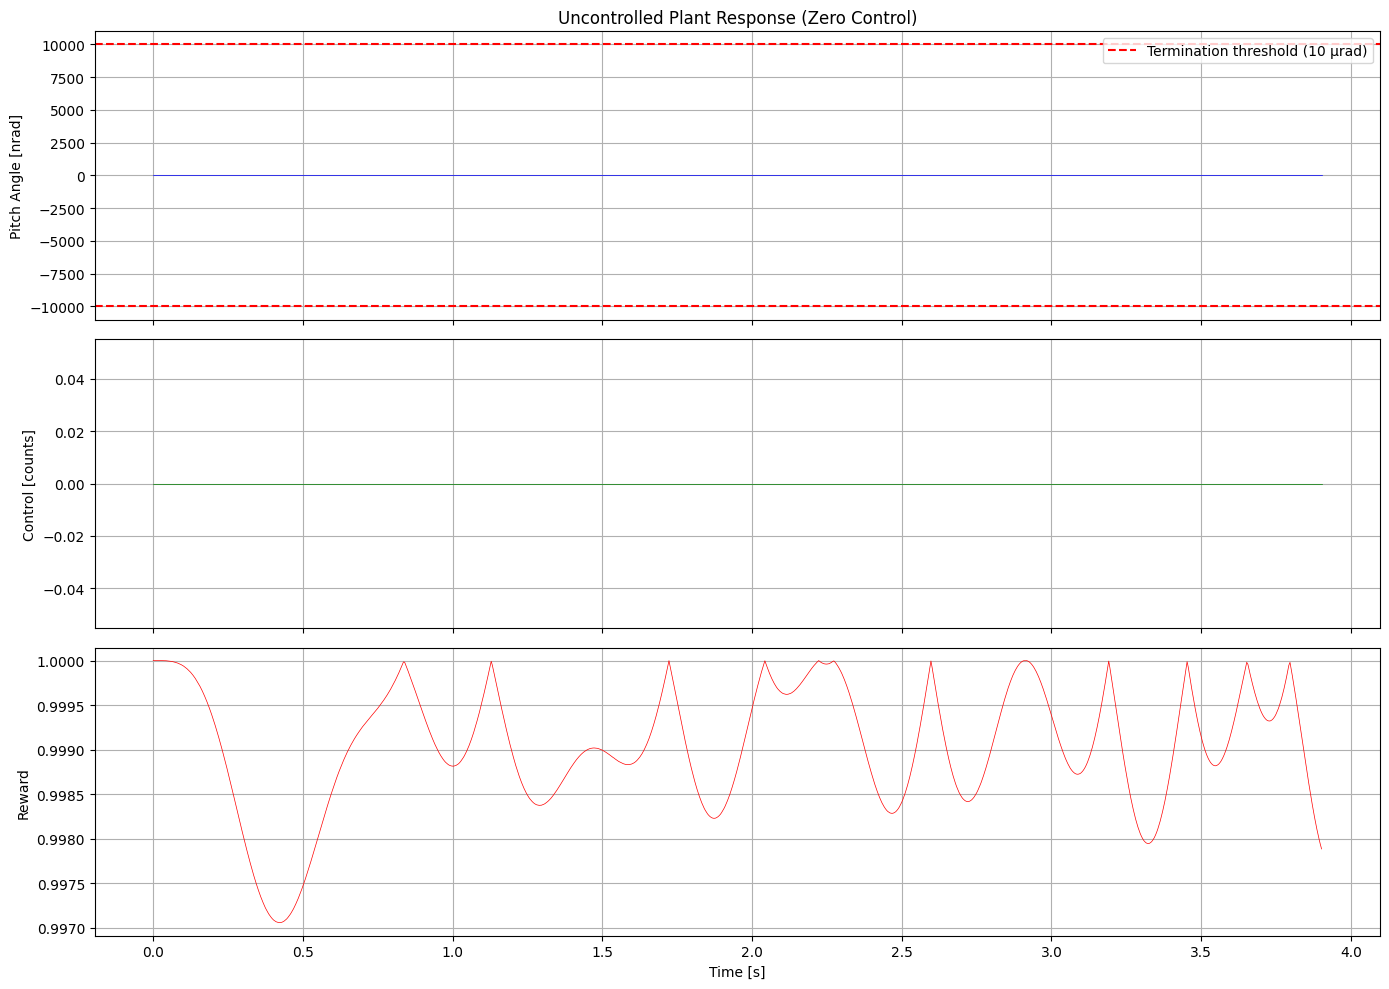

In [11]:
# Plot the uncontrolled response
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Pitch angle
axes[0].plot(time_steps, np.array(pitch_history) * 1e9, 'b-', linewidth=0.5)
axes[0].set_ylabel('Pitch Angle [nrad]')
axes[0].set_title('Uncontrolled Plant Response (Zero Control)')
axes[0].axhline(env.termination_threshold * 1e9, color='r', linestyle='--', 
                label=f'Termination threshold ({env.termination_threshold*1e6:.0f} µrad)')
axes[0].axhline(-env.termination_threshold * 1e9, color='r', linestyle='--')
axes[0].legend()
axes[0].grid(True)

# Control output
axes[1].plot(time_steps, control_history, 'g-', linewidth=0.5)
axes[1].set_ylabel('Control [counts]')
axes[1].grid(True)

# Reward
axes[2].plot(time_steps, reward_history, 'r-', linewidth=0.5)
axes[2].set_ylabel('Reward')
axes[2].set_xlabel('Time [s]')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 5. Simple Proportional Controller

Let's implement a simple proportional controller to see if we can stabilize the plant.
This demonstrates the basic control challenge.

In [12]:
# Simple proportional controller
def proportional_controller(obs, Kp=-1e7):
    """
    Simple proportional feedback controller.
    
    Args:
        obs: Observation vector (error in µrad is obs[0])
        Kp: Proportional gain (negative for negative feedback)
        
    Returns:
        Action in [-1, 1] (scaled to ±3000 counts by environment)
    """
    error_urad = obs[0]  # Already scaled to µrad in observation
    error_rad = error_urad * 1e-6
    
    # Control = Kp * error, clipped to [-1, 1]
    control = np.clip(Kp * error_rad / env.action_limit, -1, 1)
    return np.array([control])

# Run with proportional controller
obs, info = env.reset(seed=123)

pitch_history_p = []
control_history_p = []
reward_history_p = []
time_steps_p = []

n_steps = 5000  # Run more steps with control

for i in range(n_steps):
    action = proportional_controller(obs, Kp=-5e6)
    
    obs, reward, terminated, truncated, info = env.step(action)
    
    pitch_history_p.append(info['pitch_angle'])
    control_history_p.append(info['control_output'])
    reward_history_p.append(reward)
    time_steps_p.append(i / env.fs_ctrl)
    
    if terminated:
        print(f"Episode terminated at step {i}")
        break
        
print(f"Completed {len(pitch_history_p)} steps")
print(f"Final pitch angle: {pitch_history_p[-1]*1e9:.2f} nrad")
print(f"Total reward: {sum(reward_history_p):.2f}")
print(f"Average reward: {np.mean(reward_history_p):.4f}")

Episode terminated at step 59
Completed 60 steps
Final pitch angle: -10162.19 nrad
Total reward: 40.25
Average reward: 0.6708


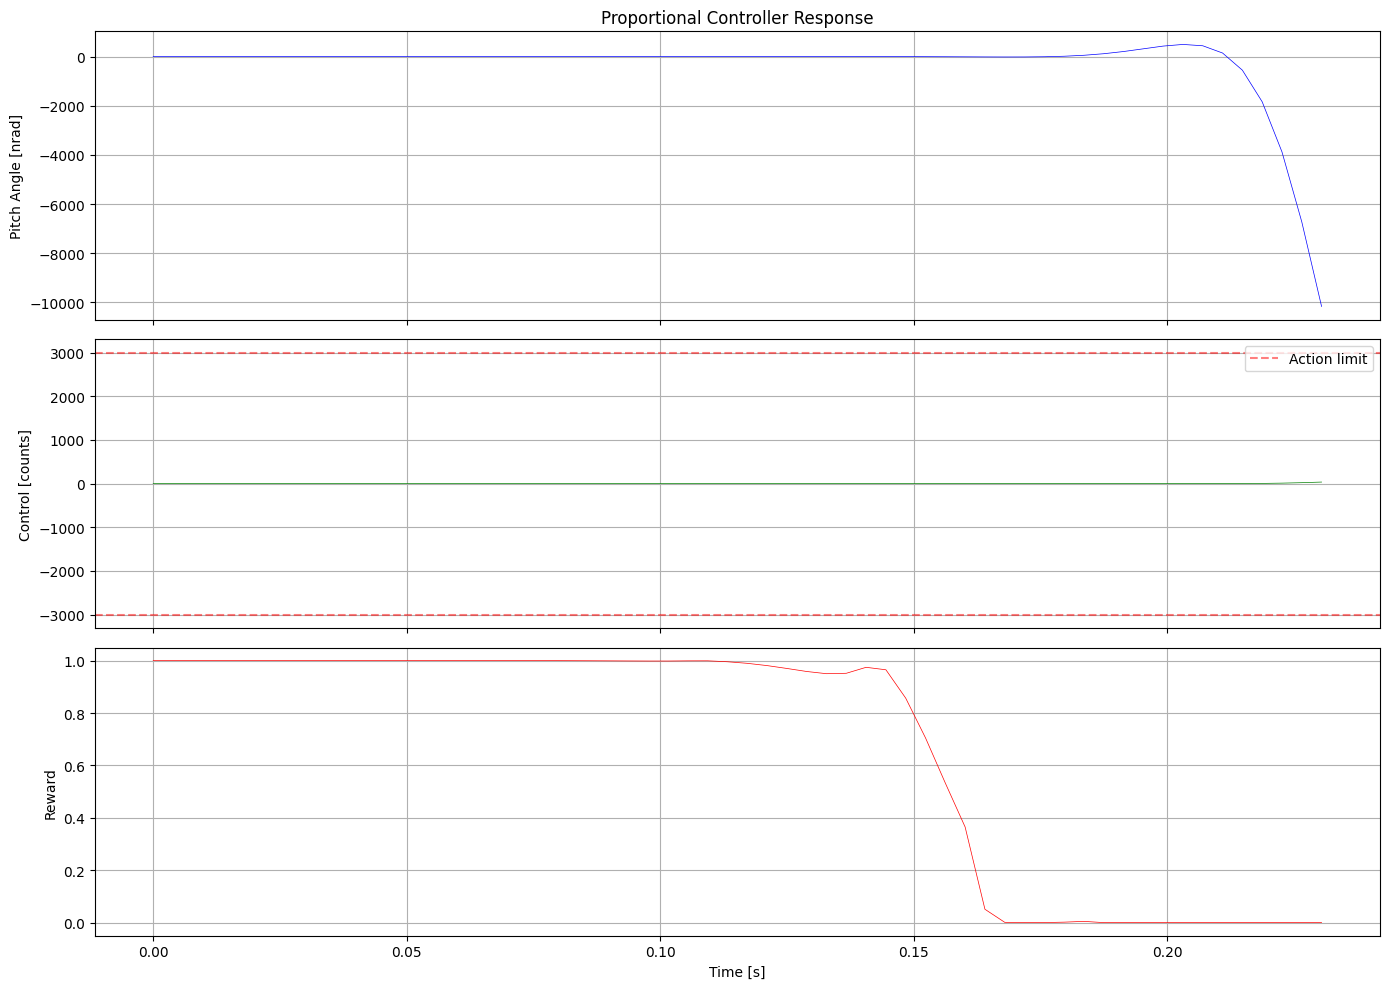

In [13]:
# Plot the controlled response
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Pitch angle
axes[0].plot(time_steps_p, np.array(pitch_history_p) * 1e9, 'b-', linewidth=0.5)
axes[0].set_ylabel('Pitch Angle [nrad]')
axes[0].set_title('Proportional Controller Response')
axes[0].grid(True)

# Control output
axes[1].plot(time_steps_p, control_history_p, 'g-', linewidth=0.5)
axes[1].set_ylabel('Control [counts]')
axes[1].axhline(3000, color='r', linestyle='--', alpha=0.5, label='Action limit')
axes[1].axhline(-3000, color='r', linestyle='--', alpha=0.5)
axes[1].legend()
axes[1].grid(True)

# Reward
axes[2].plot(time_steps_p, reward_history_p, 'r-', linewidth=0.5)
axes[2].set_ylabel('Reward')
axes[2].set_xlabel('Time [s]')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 6. Domain Randomization

The paper uses domain randomization for robust policy training (Table S3):
- **Scalar noise multiplier**: uniform [1.0, 5.0]
- **RHP pole frequency**: log-uniform [0.8, 1.2] × base frequency

Let's see how the environment parameters change across resets.

Domain Randomization Statistics:
----------------------------------------
Noise scale: mean=3.31, range=[1.34, 4.82]
RHP scale:   mean=1.02, range=[0.854, 1.194]


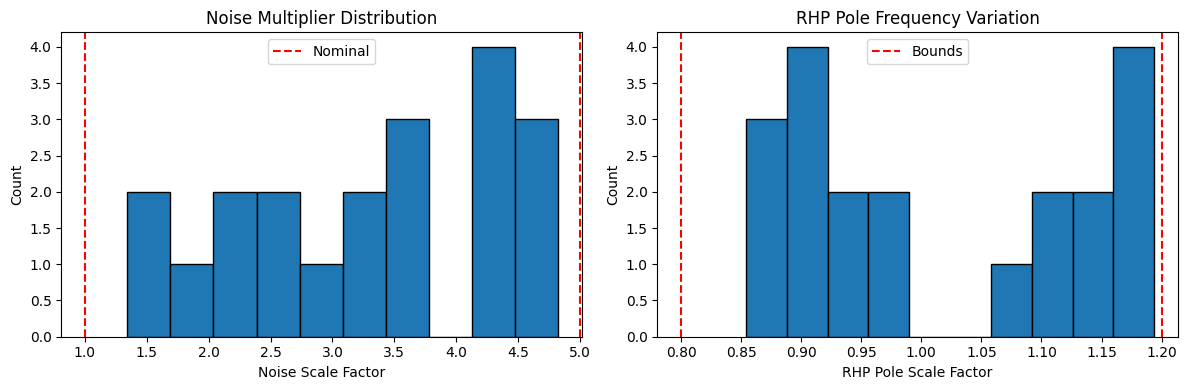

In [14]:
# Create environment with domain randomization enabled
env_dr = LIGOASCEnv(
    fs_sim=2048.0,
    fs_ctrl=256.0,
    episode_duration=64.0,
    enable_domain_randomization=True,  # Enable DR
    seed=42,
)

# Sample multiple environments to see the variation
noise_scales = []
rhp_scales = []

for i in range(20):
    obs, info = env_dr.reset(seed=i)
    noise_scales.append(info['noise_scale'])
    rhp_scales.append(info['rhp_scale'])
    
print("Domain Randomization Statistics:")
print("-" * 40)
print(f"Noise scale: mean={np.mean(noise_scales):.2f}, "
      f"range=[{np.min(noise_scales):.2f}, {np.max(noise_scales):.2f}]")
print(f"RHP scale:   mean={np.mean(rhp_scales):.2f}, "
      f"range=[{np.min(rhp_scales):.3f}, {np.max(rhp_scales):.3f}]")

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(noise_scales, bins=10, edgecolor='black')
axes[0].set_xlabel('Noise Scale Factor')
axes[0].set_ylabel('Count')
axes[0].set_title('Noise Multiplier Distribution')
axes[0].axvline(1.0, color='r', linestyle='--', label='Nominal')
axes[0].axvline(5.0, color='r', linestyle='--')
axes[0].legend()

axes[1].hist(rhp_scales, bins=10, edgecolor='black')
axes[1].set_xlabel('RHP Pole Scale Factor')
axes[1].set_ylabel('Count')
axes[1].set_title('RHP Pole Frequency Variation')
axes[1].axvline(0.8, color='r', linestyle='--', label='Bounds')
axes[1].axvline(1.2, color='r', linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Using with Stable-Baselines3 (Example)

The environment is Gymnasium-compatible and can be used directly with RL libraries like Stable-Baselines3.
Here's how you would set up training with SAC (similar to MPO used in the paper).

In [15]:
# Example: Training with Stable-Baselines3 (uncomment to run)
# Note: This requires stable-baselines3 to be installed: pip install stable-baselines3

"""
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback

# Create training environment with domain randomization
def make_env():
    return LIGOASCEnv(
        fs_sim=2048.0,
        fs_ctrl=256.0,
        episode_duration=64.0,  # Start with shorter episodes
        enable_domain_randomization=True,
        seed=None,  # Random seed for each episode
    )

# Vectorized environment with observation normalization
vec_env = DummyVecEnv([make_env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True)

# Create SAC agent
model = SAC(
    "MlpPolicy",
    vec_env,
    learning_rate=3e-4,
    buffer_size=1_000_000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=1,
)

# Training callback
eval_env = DummyVecEnv([make_env])
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./outputs/models/',
    log_path='./outputs/logs/',
    eval_freq=10000,
    n_eval_episodes=5,
)

# Train the model
model.learn(total_timesteps=1_000_000, callback=eval_callback)

# Save the trained model
model.save("ligo_asc_sac_controller")
"""

print("Training example code shown above (uncomment to run)")
print("\\nKey RL Framework Components (from paper):")
print("- MPO (Maximum a Posteriori Policy Optimization) - primary algorithm")
print("- dm_env interface (we use Gymnasium for broader compatibility)")
print("- Policy network: 256×256 MLP")
print("- Episode length: 1024 seconds at 256 Hz")

Training example code shown above (uncomment to run)
\nKey RL Framework Components (from paper):
- MPO (Maximum a Posteriori Policy Optimization) - primary algorithm
- dm_env interface (we use Gymnasium for broader compatibility)
- Policy network: 256×256 MLP
- Episode length: 1024 seconds at 256 Hz


## 8. Summary and Next Steps

### What we've built:
1. **LIGO ASC Gymnasium Environment** (`LIGOASCEnv`)
   - Linear SISO plant model with quadruple pendulum dynamics
   - Radiation pressure coupling (unstable RHP pole at ~2.4 Hz)
   - Noise generation from real LIGO O3 PSDs
   - Frequency-domain rewards (8-30 Hz observation band)
   - Domain randomization for robust training

### Key specifications (matching paper):
| Parameter | Value |
|-----------|-------|
| Simulation frequency | 2048 Hz |
| Control frequency | 256 Hz |
| Episode length | 1024 s (262,144 steps) |
| Action limits | ±3000 counts |
| Observation band | 8-30 Hz |
| Noise multiplier (DR) | [1.0, 5.0] uniform |
| RHP pole scaling (DR) | [0.8, 1.2] log-uniform |

### Next steps:
1. **Train with MPO/SAC**: Use the environment with RL libraries
2. **Integrate Lightsaber**: For full nonlinear MIMO simulation
3. **Real data validation**: Compare with experimental data from zenodo
4. **Deploy to advLigoRTS**: Interface with real-time control system